## 载入配置

In [1]:
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, interpret_model
import pandas as pd
import sys, os

sys.path.append('../')

from src import proj_dir

Use environmental variables in default.yml


## 载入测试数据

In [2]:
data = pd.read_csv(os.path.join(proj_dir, 'data/local_test/patient_data.csv'))
data.drop('INPATIENT_ID', axis = 1, inplace = True)

numeric_cols = [
    'AGE', 'ISS', 'CAPRINI_SCORE', 'T', 'P', 'R', 'MBP', 'SHOCK_INDEX', 'HEIGHT', 'WEIGHT',
    'BMI', 'RBC', 'HGB', 'PLT', 'WBC', 'ALB', 'CRE', 'UA', 'AST', 'ALT', 'GLU', 'TG', 'CHO',
    'CA', 'MG', 'LDL', 'NA', 'K', 'CL', 'GFR', 'PT', 'FIB', 'DD', 'CK', 'INR'
]

categoric_cols = [p for p in list(data.columns) if p not in ['VTE'] + numeric_cols]

for col in data.columns:
    if col == 'VTE':
        data[col] = data[col].apply(lambda x: 'pos' if x == 1 else 'neg')
    elif col in categoric_cols:
        data[col] = data[col].astype(int)
    elif col in numeric_cols:
        data[col] = data[col].astype(float)
    else:
        pass

## 创建分类模型

* numeric_features和categorical_features里不包括target.
* 可以在这里进行数据和特征处理.

In [3]:
task = setup(
    data,
    target = 'VTE',
    numeric_features = numeric_cols,
    categorical_features = categoric_cols,
    verbose = False,
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.6,
    ignore_low_variance = True,
)

INFO:logs:create_model_container 0
INFO:logs:master_model_container 0
INFO:logs:display_container 0
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['CHEMOPROPHYLAXIS',
                                                            'SEX', 'SURGERY',
                                                            'CVC', 'ICU_STAY',
                                                            'OPEN_INJURY',
                                                            'INJURY_TYPE',
                                                            'INJURY_CAUSE_fall',
                                                            'INJURY_CAUSE_traffic '
                                                            'accident',
                                                            'INJURY_CAUSE_high '
                                                            'fall',
                                                            'INJURY_

## 模型比较

自动打印各模型各指标对比表.
创建模型和训练调参.

|ID|Name|
|:--:|:--:|
|lr       |Logistic Regression            |
|knn      |K Nearest Neighbour            |
|nb       |Naive Bayes                    |
|dt       |Decision Tree Classifier       |
|svm      |SVM - Linear Kernel            |
|rbfsvm   |SVM - Radial Kernel            |
|gpc      |Gaussian Process Classifier    |
|mlp      |Multi Level Perceptron         |
|ridge    |Ridge Classifier               |
|rf       |Random Forest Classifier       |
|qda      |Quadratic Discriminant Analysis|
|ada      |Ada Boost Classifier           |
|gbc      |Gradient Boosting Classifier   |
|lda      |Linear Discriminant Analysis   |
|et       |Extra Trees Classifier         |
|xgboost  |Extreme Gradient Boosting      |
|lightgbm |Light Gradient Boosting        |
|catboost |CatBoost Classifier            |

In [4]:
model_store_final = compare_models(
    whitelist = ['lr', 'rf', 'ridge', 'xgboost'],
    sort = 'F1',
    verbose = True
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.7977,0.7894,0.3830,0.5349,0.4378,0.3217,0.3318,0.1052
1,Logistic Regression,0.7914,0.7898,0.2852,0.5198,0.3624,0.2527,0.2706,0.0389
2,Ridge Classifier,0.7994,0.0000,0.2264,0.5955,0.3192,0.2304,0.2705,0.0060
3,Random Forest Classifier,0.7898,0.7278,0.1505,0.5183,0.2295,0.1518,0.1905,0.0225


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=8286, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=0)
INFO:logs:compare_models() succesfully completed......................................


## 单模型训练

#### 创建单个模型.

In [5]:
# params = {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10}
params = {}
clf = create_model('rf', verbose = True, **params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8095,0.8123,0.1538,0.6667,0.2500,0.1871,0.2543
1,0.7937,0.6346,0.0769,0.5000,0.1333,0.0829,0.1314
2,0.7937,0.7062,0.1538,0.5000,0.2353,0.1531,0.1889
3,0.8254,0.8400,0.3077,0.6667,0.4211,0.3343,0.3690
4,0.7460,0.7915,0.0714,0.2500,0.1111,0.0137,0.0174
5,0.7937,0.7121,0.1429,0.6667,0.2353,0.1702,0.2390
6,0.7619,0.5860,0.0714,0.3333,0.1176,0.0426,0.0598
7,0.7778,0.6866,0.1429,0.5000,0.2222,0.1370,0.1740
8,0.7903,0.7096,0.1538,0.5000,0.2353,0.1516,0.1873
9,0.8065,0.7991,0.2308,0.6000,0.3333,0.2454,0.2840


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=8286, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


#### 模型调参, 使用算法为Stratified Cross Validation.

In [6]:
# TODO: 这里调参时clf中用户设定的参数也发生了改变.
clf_tuned = tune_model(clf, optimize = 'F1', n_iter = 20, fold = 10, round = 4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7937,0.7408,0.0769,0.5000,0.1333,0.0829,0.1314
1,0.7937,0.7154,0.1538,0.5000,0.2353,0.1531,0.1889
2,0.7937,0.7254,0.1538,0.5000,0.2353,0.1531,0.1889
3,0.7937,0.8600,0.1538,0.5000,0.2353,0.1531,0.1889
4,0.7460,0.7930,0.1429,0.3333,0.2000,0.0769,0.0867
5,0.8254,0.8105,0.3571,0.7143,0.4762,0.3851,0.4185
6,0.7619,0.7325,0.0714,0.3333,0.1176,0.0426,0.0598
7,0.7778,0.7988,0.1429,0.5000,0.2222,0.1370,0.1740
8,0.8065,0.8250,0.3846,0.5556,0.4545,0.3416,0.3501
9,0.8387,0.7975,0.3077,0.8000,0.4444,0.3712,0.4295


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 4
INFO:logs:RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=8286, verbose=0,
                       warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


#### 模型评估.

提供了Hyperparameters, AUC, Confusion Matrix, Threshold, PR Curve, Error, Class
Report, Feature Selection, Learning Curve, Manifold Learning, etc., 功能比较强.

In [7]:
# plot_model(clf_tuned, plot = 'auc')
evaluate_model(clf_tuned)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

IntProgress(value=0, description='Processing: ', max=5)

#### 模型解释

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=8286, verbose=0,
                       warm_start=False), plot=correlation, feature=None, observation=None)
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:plot type: correlation
INFO:logs:model type detected: type 1
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


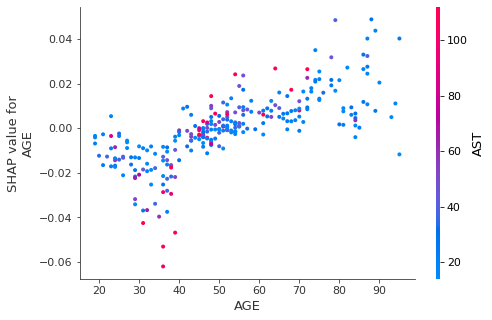

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [8]:
# TODO: 偶尔会报错, 网上查说可能是shap的bug.
# 该方法是基于树的解释方法, 只适用于树模型.
# interpret_model(clf_tuned)
interpret_model(clf_tuned, plot = 'correlation')
# interpret_model(clf_tuned, plot = 'reason', observation = 0)

## MLFlow UI

In [9]:
# TODO: 功能不明.
# !mlflow ui